# MSDS 7331 - Project 1 - Visualization
## Team: Dineen Parker, Dale Legband, Ryan Shuhart
collaboration site: https://github.com/rlshuhart/MSDS7331_Project_1

In [1]:
### Modules Used ###

# Pandas Module for data manipulation
import pandas as pd
import numpy as np

# pandas_profiling is a handy tool for inspecting data
# https://github.com/JosPolfliet/pandas-profiling
# pip install pandas-profiling
import pandas_profiling

# seaborn and matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Page settings - might not need...
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

# Prevents scientific notation formatting issues. Limits floats to one decimal place.
pd.set_option('display.float_format', lambda x: '%.3f' % x) 

# Business Understanding
Credit card companies collect voluminous amounts of data which is ripe for analysis. The data for this project was originally provided to researchers to evaluate which data mining model could best predict defaults. The value of understanding the probability of who will default in advance given past behavior was once leading edge but now required to run a profitable credit card business. 
Here we wish to understand and visulalize the data and in future project build models that best predict the probability of default for each customer. 
* This data was collected as a part of the day to day business of running a credit card business. 
* The actual defaults per person are provided.  Plenty of data is provided to run test and validation runs. 
* Bank business people, with enough accuracy, can decide on actions to help the consumers avoid default or recover quickly.
* Accuracy of the forecast is important, but perfection cannot be expected.  Therefore, business actions will need to be adjusted based on the probability of default.
  * For example, selected individuals show on time payments for many months then suddenly default 'unexpectedly'.
* Accuracy can be tracked month by month and business practices adjusted accordingly.
* For the initial modeling, understanding and organizing the data is critical.
* Assumptions include:
  * The latest bill amount BILL_AMT1_SEPT is the amount defaulted upon.
  * Various adjustments given the real data as reported below.

# Data Understanding

### Collect Initial Data
Data comes from the UCI Machine Learning Repository

http://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The given description: <br>
"This research aimed at the case of customer default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods. From the perspective of risk management, the result of predictive accuracy of the estimated probability of default will be more valuable than the binary result of classification - credible or not credible clients. Because the real probability of default is unknown, this study presented the novel Sorting Smoothing Method to estimate the real probability of default. With the real probability of default as the response variable (Y), and the predictive probability of default as the independent variable (X), the simple linear regression result (Y = A + BX) shows that the forecasting model produced by artificial neural network has the highest coefficient of determination; its regression intercept (A) is close to zero, and regression coefficient (B) to one. Therefore, among the six data mining techniques, artificial neural network is the only one that can accurately estimate the real probability of default."



In [2]:
# First row are for reference with header starting on line 2.
# ID field is use as the index field in the data frame
# Month specific columns renamed with month for readability

#use below for web download
#url = "https://github.com/rlshuhart/MSDS7331_Project_1/blob/master/cc_data/default%20of%20credit%20card%20clients.xls"

cc_data = (pd.read_excel("./cc_data/default of credit card clients.xls", skiprows=1, index_col='ID')
             .rename(columns={'PAY_0':'PAY_0_Sept', #No Pay_1
                              'PAY_2':'PAY_2_Aug', # change 'this':'to that'
                              'PAY_3':'PAY_3_July', 
                              'PAY_4':'PAY_4_June',
                              'PAY_5':'PAY_5_May',
                              'PAY_6':'PAY_6_April',
                              'BILL_AMT1':'BILL_AMT1_Sept', 
                              'BILL_AMT2':'BILL_AMT2_Aug', 
                              'BILL_AMT3':'BILL_AMT3_July', 
                              'BILL_AMT4':'BILL_AMT4_June', 
                              'BILL_AMT5':'BILL_AMT5_May',
                              'BILL_AMT6':'BILL_AMT6_April', 
                              'PAY_AMT1':'PAY_AMT1_Sept', 
                              'PAY_AMT2':'PAY_AMT2_Aug', 
                              'PAY_AMT3':'PAY_AMT3_July', 
                              'PAY_AMT4':'PAY_AMT4_June', 
                              'PAY_AMT5':'PAY_AMT5_May',
                              'PAY_AMT6':'PAY_AMT6_April'
                             })
             # Due to the many age values, creating age brackets
             .assign(AGE_range = lambda x: pd.cut(x['AGE'],[20,30,40,50,60,70,120], 6, 
                                                 labels=['21-30','31-40','41-50','51-60','61-70','71-80+']))
             # this creates a new variable for LIMIT_BAL_brackets
             .assign(LIMIT_BAL_range = lambda x: pd.cut(x['LIMIT_BAL'],[0,250000,500000,750000,1e7], 4, 
                                                 labels=['0-250k','>250k-500k','>500k-750k','>750k']))
             ## Below maps the numerical representation to categorical lable and sets object type to category
             # Did not overwrite binary default indicator, because will need 0-1 representation
             .assign(Default_Yes_No = lambda x: x['default payment next month'].apply({0:'No',
                                                                                       1:'Yes'}.get))
             .assign(SEX = lambda x: x['SEX'].apply({1:'Male', 
                                                     2:'Female'}.get))
             .assign(EDUCATION = lambda x: x['EDUCATION'].apply({1:'Graduate School', 
                                                                 2:'University',
                                                                 3:'High School',
                                                                 4:'Others'}.get))
             .assign(MARRIAGE = lambda x: x['MARRIAGE'].apply({1:'Married', 
                                                               2:'Single',
                                                               3:'Others'}.get))
                                                        
           )

print(cc_data.info())
# http://stackoverflow.com/questions/16575868/efficiently-creating-additional-columns-in-a-pandas-dataframe-using-map
# http://tomaugspurger.github.io/method-chaining.html
# http://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.Series.apply.html

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 27 columns):
LIMIT_BAL                     30000 non-null int64
SEX                           30000 non-null object
EDUCATION                     29655 non-null object
MARRIAGE                      29946 non-null object
AGE                           30000 non-null int64
PAY_0_Sept                    30000 non-null int64
PAY_2_Aug                     30000 non-null int64
PAY_3_July                    30000 non-null int64
PAY_4_June                    30000 non-null int64
PAY_5_May                     30000 non-null int64
PAY_6_April                   30000 non-null int64
BILL_AMT1_Sept                30000 non-null int64
BILL_AMT2_Aug                 30000 non-null int64
BILL_AMT3_July                30000 non-null int64
BILL_AMT4_June                30000 non-null int64
BILL_AMT5_May                 30000 non-null int64
BILL_AMT6_April               30000 non-null int64
PAY_AMT1_Sept        

### First Pass Verification of Data Quality

In [3]:
# look through categorical variables that have values not defined
cat_vars = ['SEX','EDUCATION','MARRIAGE','default payment next month', 'PAY_0_Sept',
            'PAY_2_Aug', 'PAY_3_July', 'PAY_4_June', 'PAY_5_May', 'PAY_6_April', 'AGE_range', 'LIMIT_BAL_range']

for i in range(len(cat_vars)):
    print(cat_vars[i])
    try:
        print(sorted(cc_data[cat_vars[i]].unique()))
    except TypeError: # work around to unsortable 'None'
        print(cc_data[cat_vars[i]].unique())
    print()

SEX
['Female', 'Male']

EDUCATION
['University' 'Graduate School' 'High School' None 'Others']

MARRIAGE
['Married' 'Single' 'Others' None]

default payment next month
[0, 1]

PAY_0_Sept
[-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]

PAY_2_Aug
[-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]

PAY_3_July
[-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]

PAY_4_June
[-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]

PAY_5_May
[-2, -1, 0, 2, 3, 4, 5, 6, 7, 8]

PAY_6_April
[-2, -1, 0, 2, 3, 4, 5, 6, 7, 8]

AGE_range
['21-30', '31-40', '41-50', '51-60', '61-70', '71-80+']

LIMIT_BAL_range
['0-250k', '>250k-500k', '>500k-750k', '>750k']



#### First Pass Observations
It appears EDUCATION, MARRIAGE, and PAY_0_Sept-PAY_6_April (history of past payment) have values not defined by the documentation. EDUCATION should only have values 1-4 representing graduate school(1), university(2), high school(3), and others(4), however, has 0, 5, and 6. The undefinded values make up only about 1% of the observations will be imputed to the 'others' category, 4. MARRIAGE documentation states 3 categories, married(1), single(2), and others(3), yet .2% of values are defined as 0. The value 0 for MARRIAGE will be imputed to the 'others' catgory of 3. According to the documentation, PAY_0_Sept-PAY_6_April, should have values -1 or 1-9, however, the data is different and the values range from -2 to 9. Following the logic, -2 might be two months early, -1 one month early, 0 on time, 1 one month late, and so on up to 9 where 9 represents 9 months late or more. The values -2 and 0 make up significant proportion of the data and will be kept. <br>

The next step will implement the imputatin as previously described.

In [4]:
# Impute undefined values. "~" symbol means to invert. Or for the below "not in"
cc_data.loc[(~cc_data['EDUCATION'].isin(['Graduate School','University','High School','Others'])), 'EDUCATION'] = 'Others'
cc_data.loc[(~cc_data['MARRIAGE'].isin(['Married','Single','Others'])), 'MARRIAGE'] = 'Others' 

# recheck
for i in range(len(cat_vars)):
    print(cat_vars[i])
    print(sorted(cc_data[cat_vars[i]].unique()))
    print()

SEX
['Female', 'Male']

EDUCATION
['Graduate School', 'High School', 'Others', 'University']

MARRIAGE
['Married', 'Others', 'Single']

default payment next month
[0, 1]

PAY_0_Sept
[-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]

PAY_2_Aug
[-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]

PAY_3_July
[-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]

PAY_4_June
[-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8]

PAY_5_May
[-2, -1, 0, 2, 3, 4, 5, 6, 7, 8]

PAY_6_April
[-2, -1, 0, 2, 3, 4, 5, 6, 7, 8]

AGE_range
['21-30', '31-40', '41-50', '51-60', '61-70', '71-80+']

LIMIT_BAL_range
['0-250k', '>250k-500k', '>500k-750k', '>750k']



<B><I>Categorical data appears to be in better order now.

<hr>
### Variable Profile
The next cell uses a module called "pandas_profiling" created by Jos Polfliet. An overview is given at the top of the output, proceeded by the variables. There is a toggle link to expanded the details for each variable. Output is also sent to an HTML file viewable separately for convenience.<br>

#### Variable Notes:
AGE - This variable is right skewed with a range from age 21 to 79. The average age is 35 with the median at 34. This variable is clean of outliers.

Bill Amount (BILL_AMT1_Sept - BILL_AMT6_April) - The amount of the credit card bill in Taiwan Dollar for the months April 2005 to September2015. The bill amounts across the months are highly correlated.

Default_Yes_No - This variable is the string version of 'default payment next month' translating 1 to 'Yes' and 0 to 'No.'

EDUCATION - Undergraduate degree (University) is the most common education level at 46.8%. The majority of observations (82.1%) are from individuals with an undergraduate degree (University) or better.

LIMIT_BAL - Ranges from 10k to 1mm with a median of 140k. The values are right skewed, however, no unreasonable looking outliers. The total credit limit extended to the sample is over five billion.

LIMIT_BAL_range - For analysis, LIMIT_BAL was categorized into 4 parts '0-250k', '>250k-500k', '>500k-750k', '>750k'

MARRIAGE - Single makes up the largest group at 53.2%, then Married at 45.5%, and lastly an Others group of 1.3%

Pay History (PAY_0_Sept - PAY_6_April) - The 3rd quartile for each month is zero meaning, most observations are zero or less. One month delays seem to be far more absent in months PAY_2_Aug to PAY_6_April, with PAY_5_May, PAY_6_April not having any at all and seems rather odd. Only PAY_0_Sept of 1 seems to fit as one would expect. As mentioned previously, the provided documentation does not explain the values of -2 and 0, but it can be inferred as not negative events. To resolve these problems, one solution would be to create a variable called **has_Pay_Delay** history and consolidate it to a binary TRUE/FALSE variable and, thereby, removing the month in which it occurred. 

Pay Amount (PAY_AMT1_Sept - PAY_AMT6_April) - Is the amount of the payment toward the credit card that month. About a fifth of the observations are zeros each month.

SEX - Females are the majority gender at 60.4%.

AGE_range - Variable was created by bracketing the ages from the AGE variable by 10 years ('21-30', '31-40', '41-50', '51-60', '61-70', '71-80+'). Seventy-two percent of the observations fall in to the first two categories "21-30" and "31-40."

default payment next month - This is a binary variable of 0 or 1. 22.1% of the obeservations were considered in default in October 2005 and this is the sample average.


#### Description of the Data per Offical Documentation
**LIMIT_BAL** (Ratio): Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.<br>
**SEX** (Nominal): Gender (1 = male; 2 = female)<br>
**EDUCATION** (Nominal): Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)<br>
**MARRIAGE** (Nominal): Marital status (1 = married; 2 = single; 3 = others)<BR>
**AGE** (Interval): Age (year)<BR>
**PAY_0_Sept - PAY_6_April** (Ordinal): History of past payment. The past monthly payment records (from April to September, 
2005). The measurement scale for the repayment status is: <BR>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-1 = pay duly<BR>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1 - 8 = payment delay for one to eight months <BR>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;9 = payment delay for nine months and above<BR>
**BILL_AMT1_Sept - BILL_AMT6_April** (Ratio): Amount of bill statement (NT dollar) <BR>
**PAY_AMT1_Sept - PAY_AMT6_April** (Ratio): Amount of previous payment (NT dollar) <BR>
**default payment next month** (Nominal): default payment (Yes = 1, No = 0)

In [5]:
# Survey of all variables - Open
profile = pandas_profiling.ProfileReport(cc_data)
profile.to_file(outputfile="./ProfileReport.html")
profile

Number of variables,28
Number of observations,30000
Total Missing (%),0.0%
Total size in memory,6.0 MiB
Average record size in memory,210.0 B
Numeric,17
Categorical,6
Date,0
Text (Unique),0
Rejected,5
Distinct count,56


In [6]:
# Function to show counts and proportion of a given field
def category_proportion(df, series_name):
    df_counts = pd.DataFrame({series_name + '_Count' : df.groupby(series_name)[series_name].size(), 
                  series_name+'_Prop' : df.groupby(series_name)[series_name].size().apply(
                                        lambda x: float(x) / df.groupby(series_name).size().sum()*100)}).reset_index()
    df_tots = pd.DataFrame({series_name:['_Total'],
              series_name+'_Count':df_counts[series_name + '_Count'].sum(),
              series_name+'_Prop':df_counts[series_name+'_Prop'].sum()})
    return pd.concat([df_counts,df_tots])

for i in range(len(cat_vars)):
    print(category_proportion(cc_data, cat_vars[i]))
    print()

      SEX  SEX_Count  SEX_Prop
0  Female      18112    60.373
1    Male      11888    39.627
0  _Total      30000   100.000

         EDUCATION  EDUCATION_Count  EDUCATION_Prop
0  Graduate School            10585          35.283
1      High School             4917          16.390
2           Others              468           1.560
3       University            14030          46.767
0           _Total            30000         100.000

  MARRIAGE  MARRIAGE_Count  MARRIAGE_Prop
0  Married           13659         45.530
1   Others             377          1.257
2   Single           15964         53.213
0   _Total           30000        100.000

  default payment next month  default payment next month_Count  \
0                          0                             23364   
1                          1                              6636   
0                     _Total                             30000   

   default payment next month_Prop  
0                           77.880  
1           

<hr>
## Visualization of Summary Statistics

In [7]:
%matplotlib inline

<hr>
### AGE
#### Counts

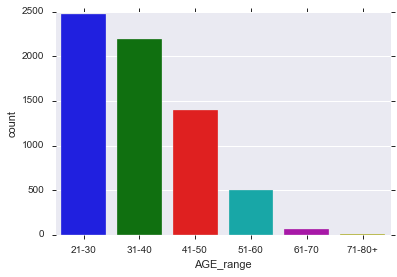

In [8]:
sns.countplot(cc_data[cc_data['default payment next month']==1]['AGE_range'])

#### Age Group by Gender
Females out number men in most age brackets. Almost twice as many females than males in the 21-30 bracket. There appears to be no outliers in age.

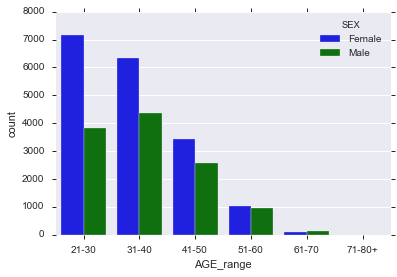

In [9]:
# Age Group by Sex
sns.countplot(data=cc_data, x='AGE_range', hue='SEX')

<hr>
#### Age Distribution by Gender
The age distribution of gender is similar. Males median age is slightly higher.

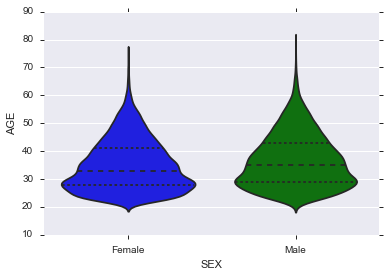

In [10]:
sns.violinplot(date=cc_data, x=cc_data['SEX'], y=cc_data['AGE'],inner="quart")

<hr>
#### Age by Marriage and SEX
The distribution of age across marriage is more centered than the single group. As one would expect, singleness preceeds marriage and occurs later in life. The 'Others' group is almost nearly normal

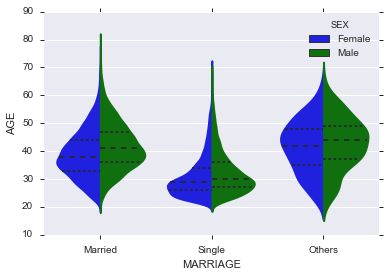

In [11]:
sns.violinplot(x=cc_data['MARRIAGE'], y=cc_data['AGE'], hue=cc_data['SEX'], split=True, inner="quart")

<hr>
#### Age by Education and Gender
Post high school graduation age appears to be less than high school educated and might be due to taking longer in life to meet certain requirements for a credit card. High School appears to be near bimodal distributions.

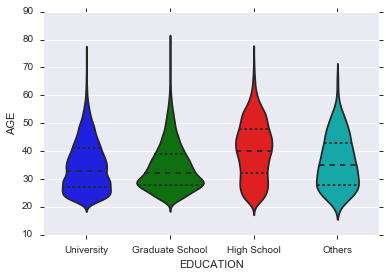

In [12]:
sns.violinplot(x=cc_data['EDUCATION'], y=cc_data['AGE'], inner="quart")

<hr>
### Education 
##### Counts
High School and Others make up a minority of the observations

In [13]:
# sns.countplot(data=cc_data, x='EDUCATION')

### Limit Balance
#### Limit Balance by Education
High School has the lowest credit limit in general, whereas, the highest educated Graduate group has the largest median credit limit. Notably, Graduate School has a multimodal distribution with 4 peaks.

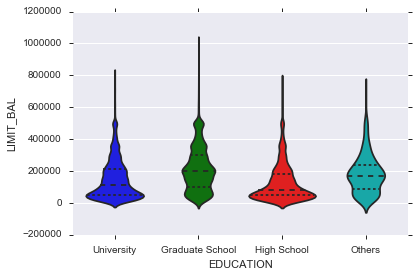

In [14]:
sns.violinplot(data=cc_data, x="EDUCATION", y='LIMIT_BAL', inner="quart")

<HR>
#### Limit Balance by AGE
There is a positive relation ship of AGE to Credit Limit

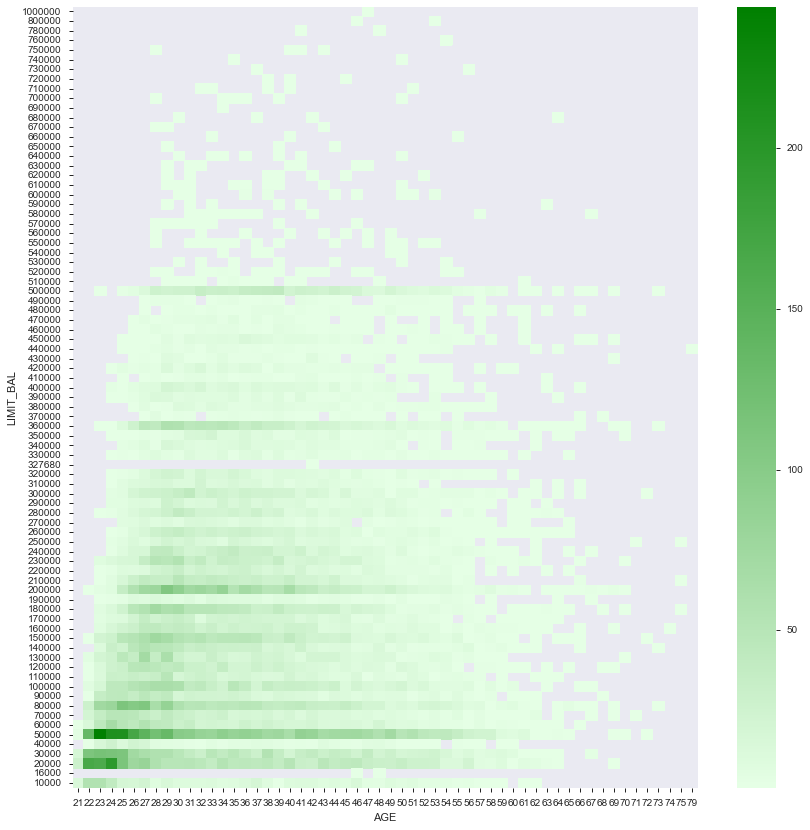

In [15]:
to_map = cc_data.groupby(['LIMIT_BAL','AGE']).size().unstack()
f = plt.figure(figsize=(14, 14))
f = sns.heatmap(to_map, cmap=sns.light_palette("green", as_cmap=True))
f.invert_yaxis()

### Distribution of Defaults

#### Average Default Rate of Sample

In [16]:
avg_default_rate = cc_data['default payment next month'].sum()/cc_data['default payment next month'].count()*100
print("The average default rate is %.1f%%" % avg_default_rate)

The average default rate is 22.1%


<hr>
#### Distibution of Default by Credit Limit
Those with lower credit limits are more likely to default.

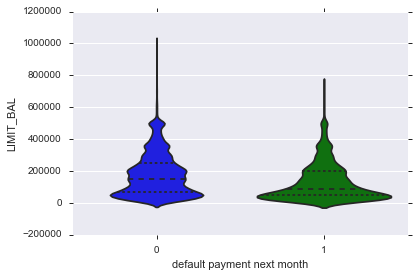

In [17]:
sns.violinplot(data=cc_data, x='default payment next month',y='LIMIT_BAL', inner="quart")

<hr>
#### Distribution of Defaults by Age and Sex Relative to the Sample Average
The age group of 71-80+ has the worst default rate regardless of gender and is 11.2 percentage points higher than the sample average. Females in the 31-40 age bracket are below average.

Frequency Table
SEX AGE_range  Female  Male
5      71-80+       6     9
4       61-70     117   140
3       51-60    1050   947
2       41-50    3418  2587
1       31-40    6350  4363
0       21-30    7171  3842


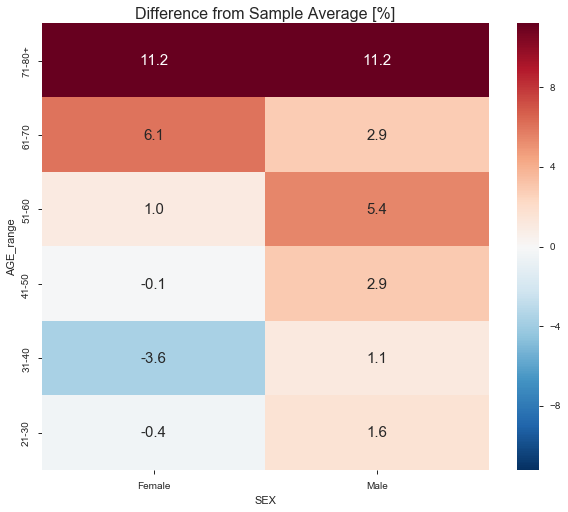

In [18]:
def heat_map(to_map):
    # Count of distribution
    df = cc_data.groupby(to_map)
    
    print("Frequency Table")
    print(df['default payment next month'].size().unstack().reset_index().sort_values(by=to_map[0], ascending=False))

    # Proportion of default
    x_count = df['default payment next month'].count().unstack()
    x_sum = df['default payment next month'].sum().unstack()

    # Relative proportion of default to the total average
    plt.figure(figsize=(10, 8))
    plt.title('Difference from Sample Average [%]', fontsize=16)
    p = sns.heatmap((x_sum/x_count)*100 - avg_default_rate, annot=True, fmt=".1f", annot_kws={"size": 15})
    p.invert_yaxis()
    
heat_map(['AGE_range','SEX'])

<hr>
#### Distribution of Defaults by Age and Education Relative to Sample Average
The eldest High School goup are the worst offenders of default. Overall the Others group does better on average, however, this group is not a frequent. Age 21-50 of Graduate School educated manage their credit card better with below average default. A negative relationship is present in the Graduate School as age increases.

Frequency Table
EDUCATION AGE_range  Graduate School  High School  Others  University
5            71-80+            4.000        7.000     nan       4.000
4             61-70           67.000      110.000   3.000      77.000
3             51-60          473.000      780.000  34.000     710.000
2             41-50         1602.000     1559.000 107.000    2737.000
1             31-40         4135.000     1380.000 164.000    5034.000
0             21-30         4304.000     1081.000 160.000    5468.000


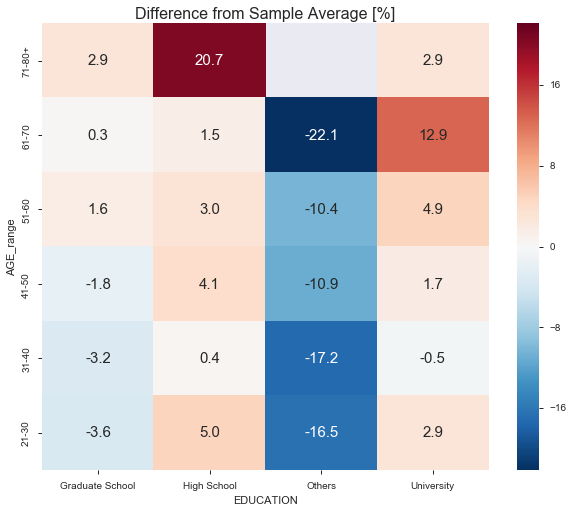

In [19]:
heat_map(['AGE_range','EDUCATION'])

<hr>
#### Distribution of Defaults by Age and Marriage
Those married tend to default more than average, whereas, single do slightly better. One could hypothesize financial pressure found commonly in marriage, such as children, could impact ability to pay.

Frequency Table
MARRIAGE AGE_range  Married  Others   Single
5           71-80+   15.000     nan      nan
4            61-70  210.000   5.000   42.000
3            51-60 1469.000  74.000  454.000
2            41-50 4362.000 141.000 1502.000
1            31-40 5722.000 101.000 4890.000
0            21-30 1881.000  56.000 9076.000


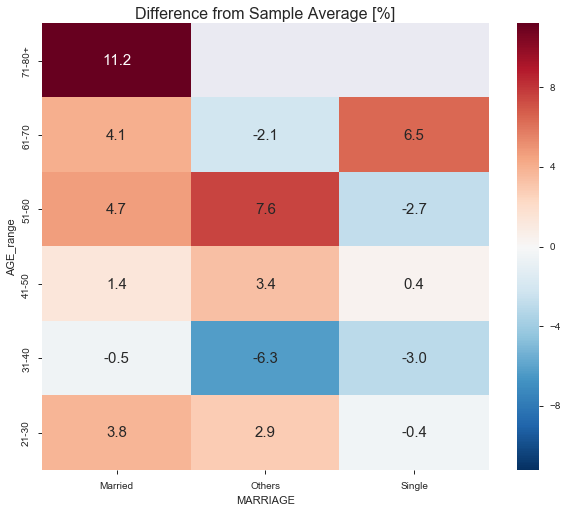

In [20]:
heat_map(['AGE_range','MARRIAGE'])

<hr>
#### Distribution of Defaults by Sex and Marriage
Men in Others category has the worse default rate. Like seen previously, men seem to have a worse default record in general. Single women have the best record.

Frequency Table
MARRIAGE     SEX  Married  Others  Single
1           Male     5190     145    6553
0         Female     8469     232    9411


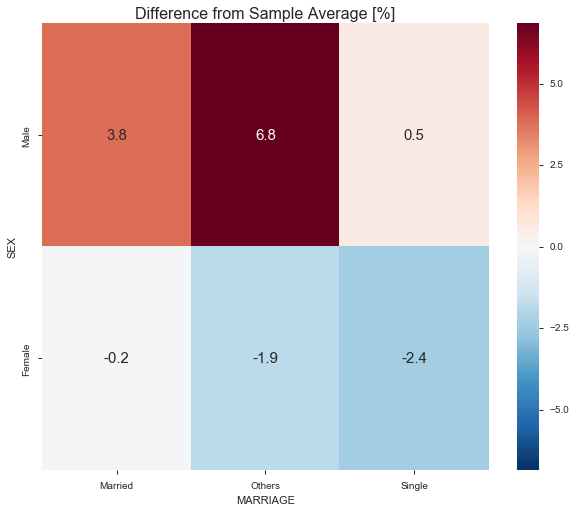

In [21]:
heat_map(['SEX','MARRIAGE'])

<hr>
#### Distribution of Defaults by Sex and Education
The Others education category default rate is extremely good, althogh there maybe some concern for the limited observations. Graduate School category show to be the better group. Gender and Education have appear to have significant association to default.

Frequency Table
EDUCATION     SEX  Graduate School  High School  Others  University
1            Male             4354         1990     170        5374
0          Female             6231         2927     298        8656


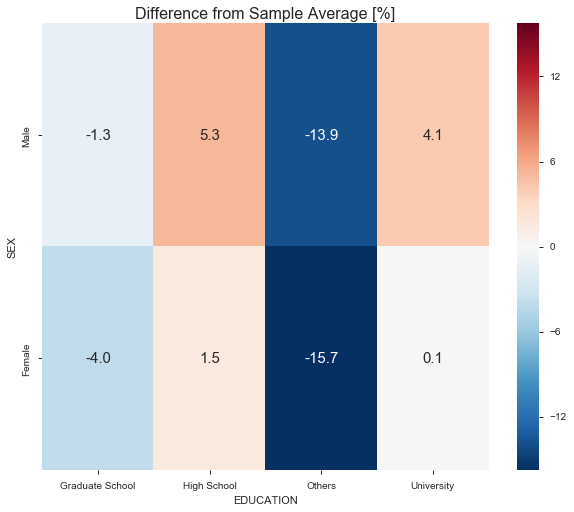

In [22]:
heat_map(['SEX','EDUCATION'])

<hr>
#### Distribution of Defaults by Marriage and Education
Both the Other categories in MARRIAGE and EDUCATION stand out as the best, but it is important to note there are only 8 observations at this intersection.  University is consistently above the sample average at all levels of MARRIAGE

Frequency Table
EDUCATION MARRIAGE  Graduate School  High School  Others  University
2           Single             6809         1909     226        7020
1           Others               54          147       8         168
0          Married             3722         2861     234        6842


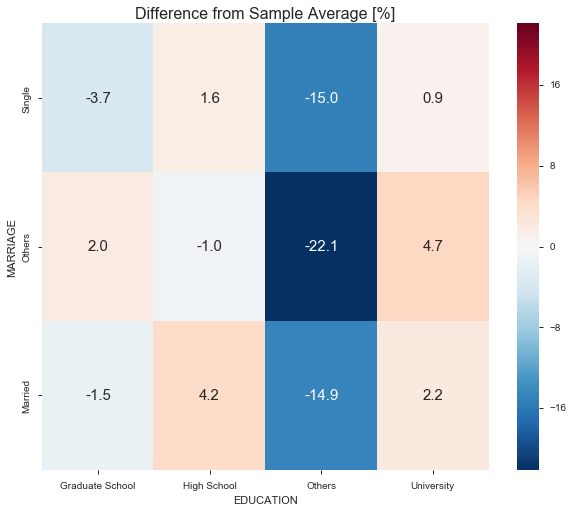

In [23]:
heat_map(['MARRIAGE','EDUCATION'])

<hr>
#### Distribution of Defaults by Age, Sex, Marriage, Education

Frequency Table
EDUCATION AGE_range     SEX MARRIAGE  Graduate School  High School  Others  \
31           71-80+    Male  Married            4.000        3.000     nan   
30           71-80+  Female  Married              nan        4.000     nan   
29            61-70    Male   Single            4.000       11.000     nan   
28            61-70    Male   Others            1.000        1.000     nan   
27            61-70    Male  Married           38.000       36.000   2.000   
26            61-70  Female   Single            5.000        9.000     nan   
25            61-70  Female   Others              nan        2.000     nan   
24            61-70  Female  Married           19.000       51.000   1.000   
22            51-60    Male   Others            6.000       15.000     nan   
21            51-60    Male  Married          227.000      235.000  11.000   
20            51-60  Female   Single           42.000      116.000   6.000   
19            51-60  Female   Others            

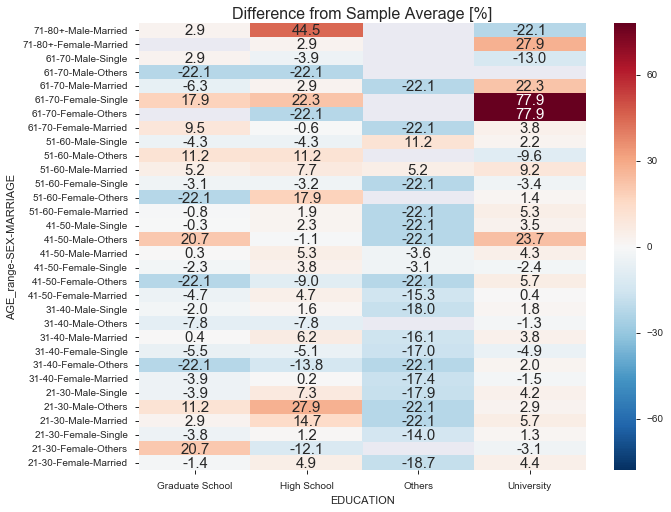

In [24]:
heat_map(['AGE_range','SEX','MARRIAGE','EDUCATION'])

<hr>
## Distribution of Defaults by Payment Delay Pattern

In [25]:
pay_delayed_default = cc_data.groupby(['PAY_0_Sept','PAY_2_Aug', 'PAY_3_July', 'PAY_4_June', 'PAY_5_May', 'PAY_6_April'])
pay_delayed_default_pattern= (pay_delayed_default['default payment next month']
                              .size()
                              .reset_index()
                              .rename(columns={0:'Count'})
                              )
pay_delayed_default_pattern[:25]

,PAY_0_Sept,PAY_2_Aug,PAY_3_July,PAY_4_June,PAY_5_May,PAY_6_April,Count
0,-2,-2,-2,-2,-2,-2,2109
1,-2,-2,-2,-2,-2,-1,88
2,-2,-2,-2,-2,-1,-1,49
3,-2,-2,-2,-2,-1,0,28
4,-2,-2,-2,-2,-1,2,8
5,-2,-2,-2,-2,0,-1,1
6,-2,-2,-2,-2,0,0,2
7,-2,-2,-2,-1,-1,-2,16
8,-2,-2,-2,-1,-1,-1,33
9,-2,-2,-2,-1,-1,0,13


In [26]:
x_count = pay_delayed_default['default payment next month'].count().reset_index()
x_sum = pay_delayed_default['default payment next month'].sum().reset_index()
prop_default = ((x_sum['default payment next month']/x_count['default payment next month'])*100)
pay_delayed_default_pattern['Default_Proportion'] = prop_default

In [27]:
# highlight patterns above the average default rate

# http://pandas.pydata.org/pandas-docs/stable/style.html
def color_above_average_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val > avg_default_rate else 'green'
    return 'color: %s' % color

cm = sns.light_palette("green", as_cmap=True)

# Top 20 payment delay patterns sorted by default frequency
(pay_delayed_default_pattern[pay_delayed_default_pattern['Count'] >50]
     .sort_values(by='Default_Proportion', ascending=False)[:50]
     #.style.background_gradient(cmap=cm, subset=['Default_Proportion'])
     .style.applymap(color_above_average_red, subset=['Default_Proportion'])
)

## Logistic Survey of Payment History for September


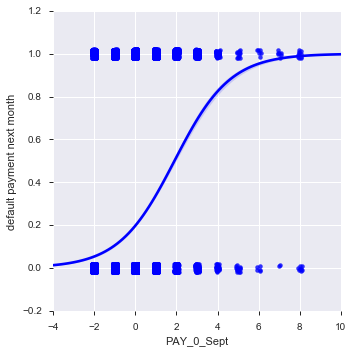

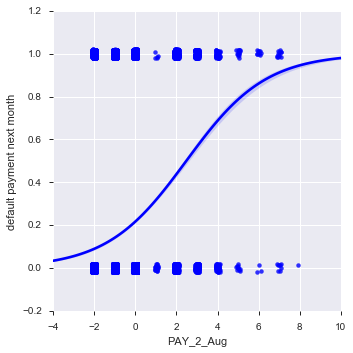

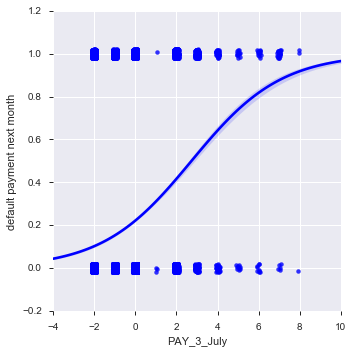

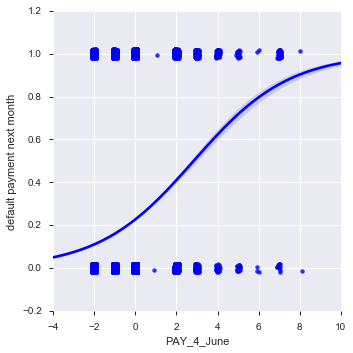

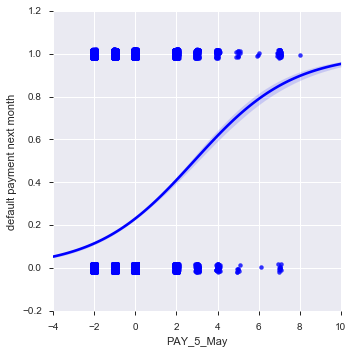

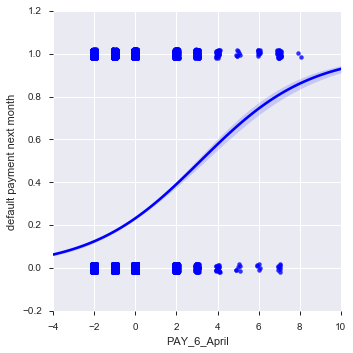

In [28]:
#Logistic line
pay_hist = ['PAY_0_Sept','PAY_2_Aug', 'PAY_3_July', 'PAY_4_June', 'PAY_5_May', 'PAY_6_April']

for i in range(len(pay_hist)):
    sns.lmplot(data=cc_data, x=pay_hist[i], y='default payment next month', x_jitter=.1, y_jitter=.02, logistic=True)
    
#sns.lmplot(data=cc_data, x='PAY_0_Sept', y='default payment next month', x_jitter=.1, y_jitter=.02, col='MARRIAGE', logistic=True)


## Feature Creation Ideas:
* Ratio of Pay Amount to Bill Amount
* Ratio of Bill Amount to LIMIT_BAL
* Transformation of data - scaling
* has_Pay_Delay - binary indicator of history of delayed payments

Sources
 - https://stanford.edu/~mwaskom/software/seaborn/index.html
 - http://pandas.pydata.org/pandas-docs/stable/index.html
 - https://www.wakari.io/sharing/bundle/ijstokes/pyvis-1h?has_login=False
 - https://github.com/mwaskom/seaborn/issues/430


# Output processed file for model selection

In [3]:
# Interesting https://annalear.ca/2010/06/10/why-excel-thinks-your-csv-is-a-sylk/
cc_data.to_csv('./cc_data/cc_data_processed.csv')